# **The Navier-Stokes equations**

Template by **Johan Hoffman**

Lab report by **Giuseppe Anagni**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Navier-Stokes equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

A flow problem described by the Navier-Stokes equations is first considered in the report, then, solutions are compared for different values of the Reynolds number and mesh resolution.
The presence or absence of a vortex street, indicative of steady or unsteady flow, is also taken into consideration.
The flow is also visualized thanks to the help of Paraview simulations, which confirms the observed results.

# **About the code**

In [1]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [2]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

from IPython.display import Video

--2024-04-21 19:04:24--  https://fem-on-colab.github.io/releases/fenics-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4161 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.06K  --.-KB/s    in 0s      

2024-04-21 19:04:24 (41.0 MB/s) - ‘/tmp/fenics-install.sh’ saved [4161/4161]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/5182fde/releases/pybind11-inst

# **Introduction**

The Navier-Stokes equations take the form:

$$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that:

$$(\dot u + (u\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term.

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula:

$$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$$

with $\Phi\in V$ a function for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization,

$$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder).

The Reynolds number is defined as $Re=\frac{UD}{\nu}$

To read more about how to use similar methods for more complex problems, see e.g.

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

The function $\texttt{lab2}$ is here defined to compare the solutions given by the solver when different input values of $\texttt{resolution}$ and Reynolds number $\texttt{Re}$ are used. The first input acts directly on the mesh, while the desired Reynolds number only changes the flow viscosity parameter, since:

$$Re=\frac{UD}{\nu}\quad\Rightarrow\quad \nu = \frac{UD}{Re},$$
and $U=1$, while $D$ is set to $2r_c=0.4$.

The function outputs the generated mesh, the velocity and pressure fields, as well as the lift and drag forces, expressed through their respective non-dimensionalizations.

In the case of unsteady flow, the Strouhal number is defined:

$$St=\frac{fD}{U},$$
with $f$ being the vortex shredding frequency (vortices shred per second: $s^{-1}$), obtained by observing the the oscillations in the lift and drag force plots.

In [3]:
def lab2 (resolution, Re):

  ############## Define domain and mesh ##############

  # Define rectangular domain
  L = 4
  H = 2

  # Define circle
  xc = 1.0
  yc = 0.5*H
  rc = 0.2

  # Define subdomains (for boundary conditions)
  class Left(SubDomain):
      def inside(self, x, on_boundary):
          return near(x[0], 0.0)

  class Right(SubDomain):
      def inside(self, x, on_boundary):
          return near(x[0], L)

  class Lower(SubDomain):
      def inside(self, x, on_boundary):
          return near(x[1], 0.0)

  class Upper(SubDomain):
      def inside(self, x, on_boundary):
          return near(x[1], H)

  left = Left()
  right = Right()
  lower = Lower()
  upper = Upper()

  # Generate mesh
  mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

  # Local mesh refinement (specified by a cell marker)
  no_levels = 0
  for i in range(0,no_levels):
    cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
    for cell in cells(mesh):
      cell_marker[cell] = False
      p = cell.midpoint()
      if p.distance(Point(xc, yc)) < 1.0:
          cell_marker[cell] = True
    mesh = refine(mesh, cell_marker)

  # Define mesh functions (for boundary conditions)
  boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
  boundaries.set_all(0)
  left.mark(boundaries, 1)
  right.mark(boundaries, 2)
  lower.mark(boundaries, 3)
  upper.mark(boundaries, 4)

  ############## Define finite element approximation spaces ##############

  # Generate finite element spaces (for velocity and pressure)
  V = VectorFunctionSpace(mesh, "Lagrange", 1)
  Q = FunctionSpace(mesh, "Lagrange", 1)

  # Define trial and test functions
  u = TrialFunction(V)
  p = TrialFunction(Q)
  v = TestFunction(V)
  q = TestFunction(Q)

  ############## Define boundary conditions ##############

  class DirichletBoundaryLower(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and near(x[1], 0.0)

  class DirichletBoundaryUpper(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and near(x[1], H)

  class DirichletBoundaryLeft(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and near(x[0], 0.0)

  class DirichletBoundaryRight(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and near(x[0], L)

  class DirichletBoundaryObjects(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

  dbc_lower = DirichletBoundaryLower()
  dbc_upper = DirichletBoundaryUpper()
  dbc_left = DirichletBoundaryLeft()
  dbc_right = DirichletBoundaryRight()
  dbc_objects = DirichletBoundaryObjects()

  uin = 1.0 ### Inflow velocity - Reference velocity for Re, St, Lift, Drag

  bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
  bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
  bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
  bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
  bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
  bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
  bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
  bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

  pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
  pout = 0.0
  #bcp0 = DirichletBC(Q, pin, dbc_left)
  bcp1 = DirichletBC(Q, pout, dbc_right)

  #bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
  bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
  bcp = [bcp1]

  # Define measure for boundary integration
  ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

  ############## Define flow parameters ##############

  ### Set viscosity based on the desired Reynolds number
  nu = uin*2*rc/Re

  ############## Define method parameters ##############

  # Define iteration functions
  # (u0,p0) solution from previous time step
  # (u1,p1) linearized solution at present time step
  u0 = Function(V)
  u1 = Function(V)
  p0 = Function(Q)
  p1 = Function(Q)

  # Set parameters for nonlinear and linear solvers
  num_nnlin_iter = 5
  prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

  # Time step length
  dt = 0.5*mesh.hmin()

  ############## Define variational problem ##############

  # Stabilization parameters
  h = CellDiameter(mesh);
  u_mag = sqrt(dot(u1,u1))
  d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
  d2 = h*u_mag

  # Mean velocities for trapozoidal time stepping
  um = 0.5*(u + u0)
  um1 = 0.5*(u1 + u0)

  # Momentum variational equation on residual form
  Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
      + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx
  au = lhs(Fu)
  Lu = rhs(Fu)

  # Continuity variational equation on residual form
  Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx
  ap = lhs(Fp)
  Lp = rhs(Fp)

  ############## Compute forces on boundary ##############

  # Normalization term
  diam = 2*rc ### Diameter of the cylinder
  normalization = -2.0/diam ### Since coeff = (2*Force)/diam if uin = 1.0

  ##### Lift calculations #####

  # Define the direction of the force to be computed
  phi_x = 0.0
  phi_y = 1.0

  psi_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
  psi = interpolate(psi_expression, V)

  LiftForce = inner((u1 - u0)/dt + grad(um1)*um1, psi)*dx - p1*div(psi)*dx + nu*inner(grad(um1), grad(psi))*dx

  ##### Drag calculations #####

  # Define the direction of the force to be computed
  phi_x = 1.0
  phi_y = 0.0

  psi_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
  psi = interpolate(psi_expression, V)

  DragForce = inner((u1 - u0)/dt + grad(um1)*um1, psi)*dx - p1*div(psi)*dx + nu*inner(grad(um1), grad(psi))*dx

  ############## Set plotting variables and open export files ##############

  # Open files to export solution to Paraview
  file_u = File("results-NS/u.pvd")
  file_p = File("results-NS/p.pvd")

  # Set plot frequency
  plot_time = 0
  plot_freq = 10

  # Force computation data
  lift_force_array = np.array(0.0)
  lift_force_array = np.delete(lift_force_array, 0)
  drag_force_array = np.array(0.0)
  drag_force_array = np.delete(drag_force_array, 0)
  time = np.array(0.0)
  time = np.delete(time, 0)
  start_sample_time = 1.0

  ############## Time stepping algorithm ##############

  !rm results-NS/*

  # Time stepping
  T = 30
  t = dt
  while t < T + DOLFIN_EPS:

      #s = 'Time t = ' + repr(t)
      #print(s)

      pin.t = t
      #uin.t = t

      # Solve non-linear problem
      k = 0
      while k < num_nnlin_iter:

          # Assemble momentum matrix and vector
          Au = assemble(au)
          bu = assemble(Lu)

          # Compute velocity solution
          [bc.apply(Au, bu) for bc in bcu]
          [bc.apply(u1.vector()) for bc in bcu]
          solve(Au, u1.vector(), bu, "bicgstab", "default")

          # Assemble continuity matrix and vector
          Ap = assemble(ap)
          bp = assemble(Lp)

          # Compute pressure solution
          [bc.apply(Ap, bp) for bc in bcp]
          [bc.apply(p1.vector()) for bc in bcp]
          solve(Ap, p1.vector(), bp, "bicgstab", prec)

          # Compute forces
          FLift, FDrag = assemble(LiftForce), assemble(DragForce)
          if (t > start_sample_time):
            lift_force_array = np.append(lift_force_array, normalization*FLift)
            drag_force_array = np.append(drag_force_array, normalization*FDrag)
            time = np.append(time, t)

          k += 1

      if t > plot_time:

          # s = 'Time t = ' + repr(t)
          # print(s)

          # Save solution to file
          file_u << u1
          file_p << p1

          # Plot solution
          # plt.figure()
          # plot(u1, title="Velocity")

          # plt.figure()
          # plot(p1, title="Pressure")

          # plot_time += T/plot_freq

          # plt.show()

          # plt.figure()
          # plt.title("Lift Force")
          # plt.plot(time, lift_force_array)
          # plt.show()

          # plt.figure()
          # plt.title("Drag Force")
          # plt.plot(time, drag_force_array)
          # plt.show()

      # Update time step
      u0.assign(u1)
      t += dt

  ############## Paraview ##############

  if resolution == 32 and Re == 100:
    !tar -czvf results-NS.tar.gz results-NS
    files.download('results-NS.tar.gz')

  return mesh, u1, p1, lift_force_array, drag_force_array, time



# **Results**

The function $\texttt{lab2}$ is now called for different resolutions and Reynolds numbers as arguments, such that:
$$Re = [1,10,100,1000],\quad \text{Resolution} = [8,16,32],$$
with the aim of comparing the various results.

First, only a change in $Re$ is considered, for a constant mesh size of $32$.

In [4]:
[Mesh, Velocity1, Pressure1, Lift1, Drag1, Time] = lab2(32, 1)
[Mesh, Velocity10, Pressure10, Lift10, Drag10, Time] = lab2(32, 10)
[Mesh, Velocity100, Pressure100, Lift100, Drag100, Time] = lab2(32, 100)
[Mesh, Velocity1000, Pressure1000, Lift1000, Drag1000, Time] = lab2(32, 1000)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_4f750817ecc896f3bedcb4ff8c9f3352153b1b38

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00728703 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.544151 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00352287 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0176198 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

rm: cannot remove 'results-NS/*': No such file or directory
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_f6002749748979e58e42737d0ad4f9e7e4b5fa4b

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    2
  Coefficients:              '[f_45, f_48]'
  Unique elements:           'Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 10
INFO:FFC:  quadrature_degree: 10
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0805264 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:---------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_899f792bca9deb3c3f12f5cb62d42f0545d411ea

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00301933 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0224516 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_79dd4099c4e669212673d783637297ee756e6a33

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00562525 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0219586 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_66170f427fb7c9d9caadb39d728b0be317507df5

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00538349 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0111206 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_2e9b89d090491583c4a1adc15502b5a159366a8a

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    3
  Coefficients:              '[f_45, f_48, f_54]'
  Unique elements:           'Vector<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 10
INFO:FFC:  quadrature_degree: 10
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0508068 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:----------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_46b9e65fcb4b2fb5349cd2071e9b331e33eac0a7

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_48]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 8
INFO:FFC:  quadrature_degree: 8
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.051796 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:--------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_a13d0e7e30e9812ee35e12056888e5df899015d5

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    2
  Coefficients:              '[f_45, f_48]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 9
INFO:FFC:  quadrature_degree: 9
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0656345 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_c7947f677c6b1226c639990866875b3b46c85998

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    4
  Coefficients:              '[f_45, f_48, f_54, f_58]'
  Unique elements:           'Vector<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0375249 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:---------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_c384d9d017bcf4a7efe7798f43cda638e03aff41

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    2
  Coefficients:              '[f_101460, f_101463]'
  Unique elements:           'Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 10
INFO:FFC:  quadrature_degree: 10
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0966167 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_dcc2baf12b2c99625d26a4409965075f59a364d6

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    3
  Coefficients:              '[f_101460, f_101463, f_101469]'
  Unique elements:           'Vector<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 10
INFO:FFC:  quadrature_degree: 10
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0646486 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:----

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_eb1c849727ff567da07b1d3141b61c55ca14d369

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    4
  Coefficients:              '[f_101460, f_101463, f_101469, f_101473]'
  Unique elements:           'Vector<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0440099 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_9a2e6ba300e8e77918a9ad5b48e6ae34cc251f8f

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    2
  Coefficients:              '[f_202875, f_202878]'
  Unique elements:           'Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 10
INFO:FFC:  quadrature_degree: 10
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0737357 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_c5f2d4076211210d93a0f5a6dbb45672bc096862

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    3
  Coefficients:              '[f_202875, f_202878, f_202884]'
  Unique elements:           'Vector<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 10
INFO:FFC:  quadrature_degree: 10
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0636024 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:----

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_595219e2b6a71aa9a1e7ca1d4c5f29b88d415199

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    4
  Coefficients:              '[f_202875, f_202878, f_202884, f_202888]'
  Unique elements:           'Vector<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.045233 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:

results-NS/
results-NS/p000477.vtu
results-NS/p000415.vtu
results-NS/p000468.vtu
results-NS/p000077.vtu
results-NS/u000528.vtu
results-NS/u000885.vtu
results-NS/u000835.vtu
results-NS/u000424.vtu
results-NS/u000459.vtu
results-NS/p000210.vtu
results-NS/u000820.vtu
results-NS/p000826.vtu
results-NS/p000543.vtu
results-NS/u000060.vtu
results-NS/u000014.vtu
results-NS/p000123.vtu
results-NS/u000626.vtu
results-NS/p000045.vtu
results-NS/p000237.vtu
results-NS/p000595.vtu
results-NS/u000772.vtu
results-NS/u000547.vtu
results-NS/u000584.vtu
results-NS/p000746.vtu
results-NS/u000098.vtu
results-NS/p000508.vtu
results-NS/p000280.vtu
results-NS/u000662.vtu
results-NS/p000247.vtu
results-NS/u000076.vtu
results-NS/u000897.vtu
results-NS/p000022.vtu
results-NS/u000005.vtu
results-NS/u000063.vtu
results-NS/p000863.vtu
results-NS/p000606.vtu
results-NS/u000508.vtu
results-NS/p000212.vtu
results-NS/p000453.vtu
results-NS/u000568.vtu
results-NS/u000154.vtu
results-NS/u000754.vtu
results-NS/p000497.vtu

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_3ff34d8f1b361e442e3c95eb987bf8a5b8d7723c

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    2
  Coefficients:              '[f_304290, f_304293]'
  Unique elements:           'Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 10
INFO:FFC:  quadrature_degree: 10
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0623488 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_7b9524f1cb973c49fa26ab3e6750d568194e1793

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    3
  Coefficients:              '[f_304290, f_304293, f_304299]'
  Unique elements:           'Vector<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 10
INFO:FFC:  quadrature_degree: 10
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0552301 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:----

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_1ff6d1dcea145d80232105f51f193fda2da87cb2

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    4
  Coefficients:              '[f_304290, f_304293, f_304299, f_304303]'
  Unique elements:           'Vector<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.057312 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:

The meshed domain and the (non-dimensionalized) lift and drag forces as functions of time can be seen in the plots below, for the four diffrent cases. The flow is observed for $30$ seconds, so the forces are considered in this timescale.

It's clear how, for the first two Reynolds numbers of $Re=1,10$ (which translate into a viscosity $\nu=0.4, 0.04)$ the forces appear stable: albeit some oscillations present for the first few seconds, the two coefficients stabilize quickly and converge to a stable value. As expected, the lift coefficient is close to zero for such low $Re$, while the impact of drag is significant.

Conversely, for $Re = 100,1000$, drag is reduced and lift increases, but most importantly the two coefficients lose their previous stability and instead oscillate heavily around some mean value: the flow has become unsteady.

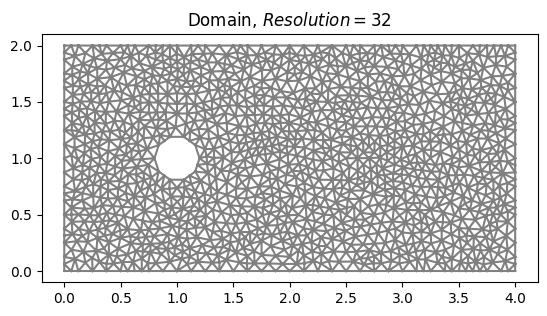

Text(0.5, 1.0, '$Re = 1000$')

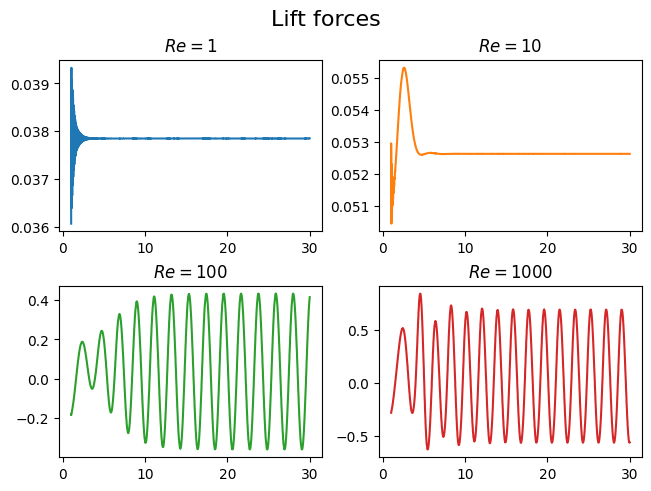

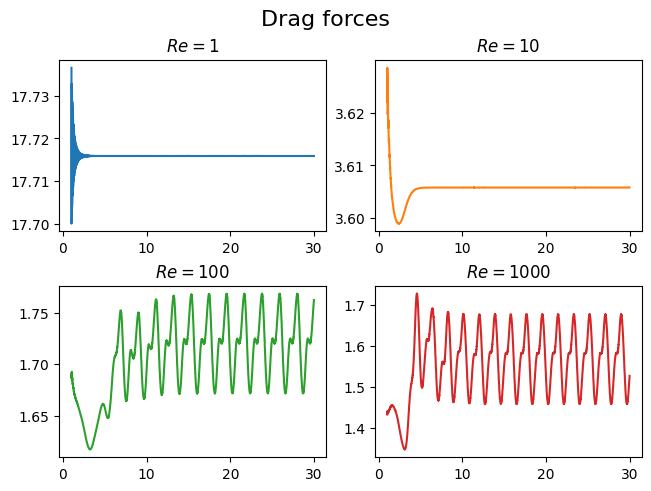

In [5]:
plt.figure()
plot(Mesh, title="Domain, $Resolution=32$")
plt.show()

fig, axs = plt.subplots(2, 2, layout="constrained",)
fig.suptitle('Lift forces', fontsize=16)
axs[0, 0].plot(Time,Lift1)
axs[0, 0].set_title('$Re = 1$')
axs[0, 1].plot(Time,Lift10, 'tab:orange')
axs[0, 1].set_title('$Re = 10$')
axs[1, 0].plot(Time,Lift100, 'tab:green')
axs[1, 0].set_title('$Re = 100$')
axs[1, 1].plot(Time,Lift1000, 'tab:red')
axs[1, 1].set_title('$Re = 1000$')

fig, axs = plt.subplots(2, 2, layout="constrained",)
fig.suptitle('Drag forces', fontsize=16)
axs[0, 0].plot(Time,Drag1)
axs[0, 0].set_title('$Re = 1$')
axs[0, 1].plot(Time,Drag10, 'tab:orange')
axs[0, 1].set_title('$Re = 10$')
axs[1, 0].plot(Time,Drag100, 'tab:green')
axs[1, 0].set_title('$Re = 100$')
axs[1, 1].plot(Time,Drag1000, 'tab:red')
axs[1, 1].set_title('$Re = 1000$')

To validate the previous statements, the velocity and pressure fields are plotted below (at the final plot time, around $30$ seconds) for the four cases.

As hinted before, in the cases of $Re=1,10$, the flow appears steady and only a wake of growing magnitude can be observed downstream of the obstacle, for both fields: no vortices are present.

For the values of $Re=100,1000$, instead, vortices can be seen to shred downstream of the obstacle, giving rise to a Von Kármán vortex street, sign of unsteady flow conditions.

In these two cases, by looking at the previous plots for the lift and drag forces, the shredding frequency can be obtained by counting the peaks reached by, for example, the lift coefficient.
Since:

$$f_{100}\simeq \frac{14}{30}\frac{\text{vortices}}{s}=0.467\,s^{-1}\quad f_{1000}\simeq\frac{15}{30}\frac{\text{vortices}}{s}=0.5\,s^{-1},$$
then:

$$St_{100}\simeq0.19\quad\text{and}\quad St_{1000} \simeq 0.2,$$

confirming a value of $St\simeq0.2$ for the Von Kármán vortex street in the two unsteady flow cases.

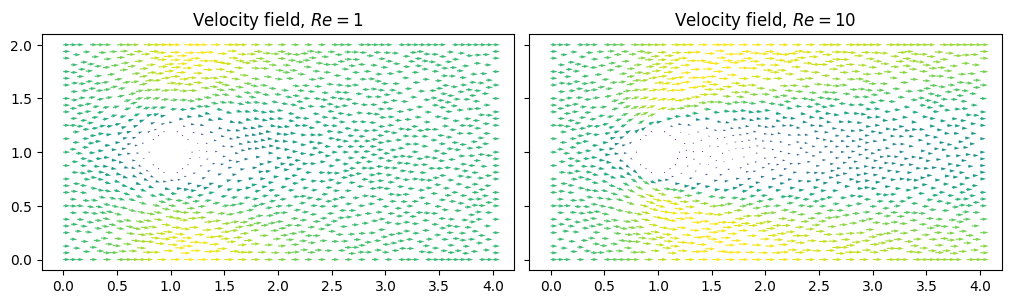

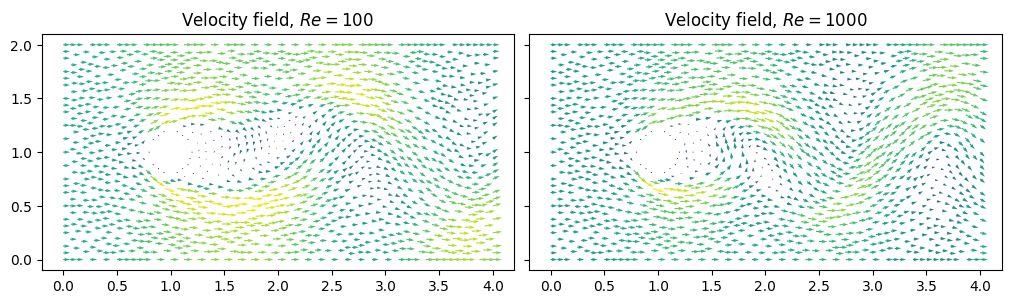

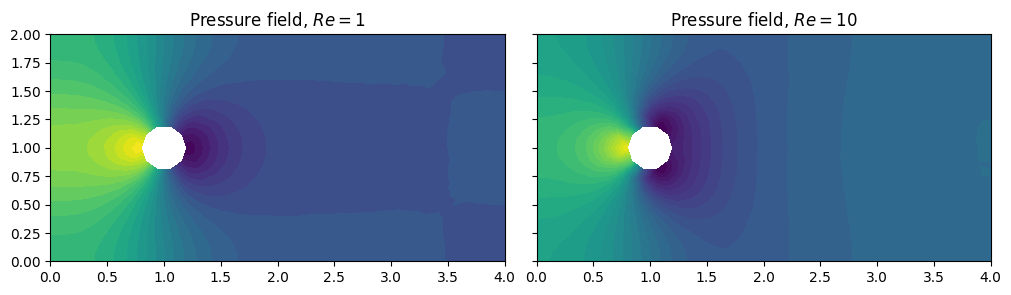

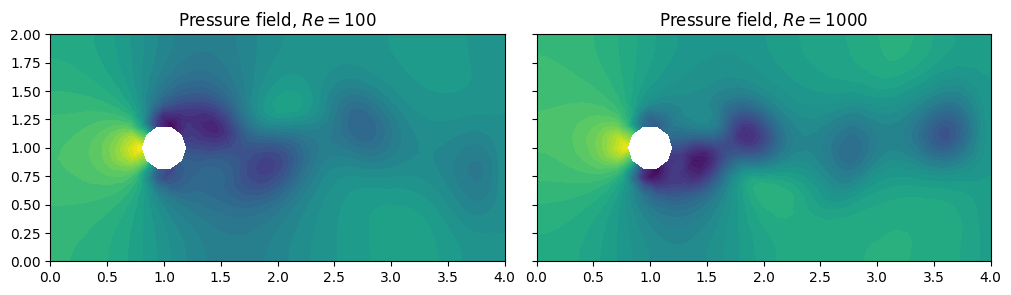

In [6]:
fig, axs = plt.subplots(1, 2, layout='constrained', figsize=(10, 12))
plt.sca(axs[0])
plot(Velocity1, title="Velocity field, $Re=1$")
plt.sca(axs[1])
plot(Velocity10, title="Velocity field, $Re=10$")
for ax in fig.get_axes():
  ax.label_outer()

fig, axs = plt.subplots(1, 2, layout='constrained', figsize=(10, 12))
plt.sca(axs[0])
plot(Velocity100, title="Velocity field, $Re=100$")
plt.sca(axs[1])
plot(Velocity1000, title="Velocity field, $Re=1000$")
for ax in fig.get_axes():
  ax.label_outer()

fig, axs = plt.subplots(1, 2, layout='constrained', figsize=(10, 12))
plt.sca(axs[0])
plot(Pressure1, title="Pressure field, $Re=1$")
plt.sca(axs[1])
plot(Pressure10, title="Pressure field, $Re=10$")
for ax in fig.get_axes():
  ax.label_outer()

fig, axs = plt.subplots(1, 2, layout='constrained', figsize=(10, 12))
plt.sca(axs[0])
plot(Pressure100, title="Pressure field, $Re=100$")
plt.sca(axs[1])
plot(Pressure1000, title="Pressure field, $Re=1000$")
for ax in fig.get_axes():
  ax.label_outer()

plt.show()

The function $\texttt{lab2}$ is now called again in order to investigate the effect on the flow of the different mesh resolutions of $8,16$ and $32$, while keeping the Reynolds number at $100$.

In [7]:
[Mesh8, Velocity8, Pressure8, Lift8, Drag8, Time8] = lab2(8, 100)
[Mesh16, Velocity16, Pressure16, Lift16, Drag16, Time16] = lab2(16, 100)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_4740162f09b24425c88d9dd9de150a9152e33a22

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    2
  Coefficients:              '[f_405705, f_405708]'
  Unique elements:           'Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 10
INFO:FFC:  quadrature_degree: 10
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0518417 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_e11d571405207eb7173680a8fb079e731093a435

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    3
  Coefficients:              '[f_405705, f_405708, f_405714]'
  Unique elements:           'Vector<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 10
INFO:FFC:  quadrature_degree: 10
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0584865 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:----

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_cf3bfc71b68f1745a5c423137a997864be546cba

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_405708]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 8
INFO:FFC:  quadrature_degree: 8
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0394242 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:---------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_55e8d1ddccbb3e3f4f83d51f5f337c79af1a0cca

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    2
  Coefficients:              '[f_405705, f_405708]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 9
INFO:FFC:  quadrature_degree: 9
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0495701 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:----------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_9e932be80a8140a13b9a0b8eaf65db3a3656d7de

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    4
  Coefficients:              '[f_405705, f_405708, f_405714, f_405718]'
  Unique elements:           'Vector<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.043328 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_b52deac41cc28f340824d9441c547b298c5ae77c

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    2
  Coefficients:              '[f_431196, f_431199]'
  Unique elements:           'Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 10
INFO:FFC:  quadrature_degree: 10
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0516081 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_461d74dd0c4fd314ef430aacadc333193ec1e1a5

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    3
  Coefficients:              '[f_431196, f_431199, f_431205]'
  Unique elements:           'Vector<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 10
INFO:FFC:  quadrature_degree: 10
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.082726 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-----

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_81ab3dfd18d973df8e1564d1bf502515a9268fdb

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_431199]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 8
INFO:FFC:  quadrature_degree: 8
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0365212 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:---------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_535c012ad1ec0c5b410fe573e31eba2914aeee9c

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    2
  Coefficients:              '[f_431196, f_431199]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 9
INFO:FFC:  quadrature_degree: 9
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0460992 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:----------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_49196314b68b790facf737f7c08c95b710f3d02d

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    4
  Coefficients:              '[f_431196, f_431199, f_431205, f_431209]'
  Unique elements:           'Vector<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0499325 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC

The mesh computed with the desired resolution, as well as the (non-dimensionalized) lift and drag forces and the velocity and pressure fields are shown in sequence for the three cases.

For the low resolution of $h=1/8$, the cylinder is around the size of the mesh, and the unsteady phenomena associated with the Reynolds number of $100$ cannot be captured accurately. In fact, the force coefficients now appear to converge to a set value, instead of oscillating around it, and the velocity/pressure fields show no sign of a vortex street: the flow appears steady!
In this case, since $f=0$ (no vortices are shred, and there are no significant oscillations for the forces), the Strouhal number is zero.

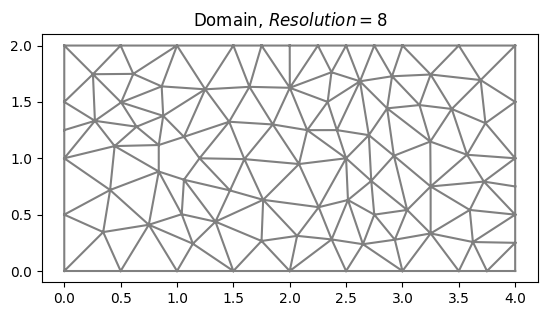

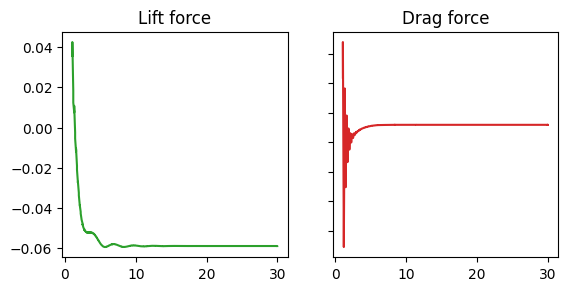

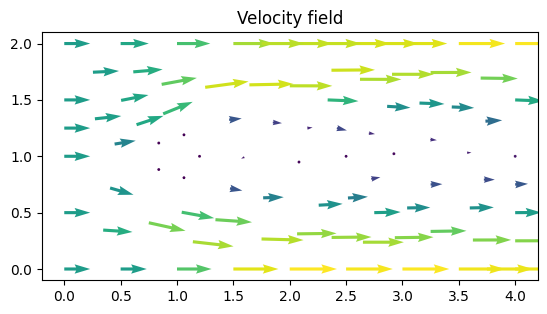

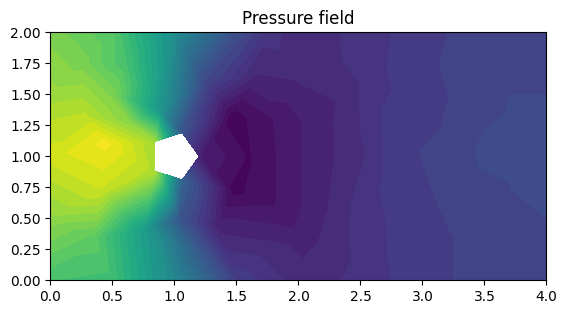

In [8]:
plt.figure()
plot(Mesh8, title="Domain, $Resolution = 8$")
plt.show()

fig, axs = plt.subplots(1,2)
axs[0].plot(Time8,Lift8, 'tab:green')
axs[0].set_title('Lift force')
axs[1].plot(Time8,Drag8, 'tab:red')
axs[1].set_title('Drag force')
for ax in fig.get_axes():
    ax.label_outer()
    ax.set_box_aspect(1)

plt.figure()
plot(Velocity8, title="Velocity field")
plt.show()

plt.figure()
plot(Pressure8, title="Pressure field")
plt.show()

The attributes of unsteady flow appear again by increasing the mesh size to $h=1/16$, although the results are diffrent compared to the case of $h=1/32$ shown before for $Re=100$.

The velocity and pressure fields now appear less detailed, as expected from using a lower resolution, however the Von Kármán vortex street is clearly noticeable, especially in the pressure plot.
The oscillations in the drag and lift coefficients are also different: they start later in time, their amplitude is lower and there are less peaks.
Because of this, the vortex shredding frequency is lower, and so is the Strouhal number:

$$f_{16}\simeq \frac{9}{30}\frac{\text{vortices}}{s}=0.3\,s^{-1}\quad\Rightarrow\quad St_{16}\simeq0.12.$$

Then, for such a resolution, the usual value of $St\simeq0.2$ for the vortex street is not confirmed.

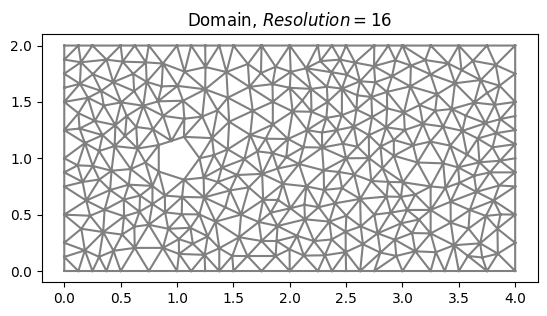

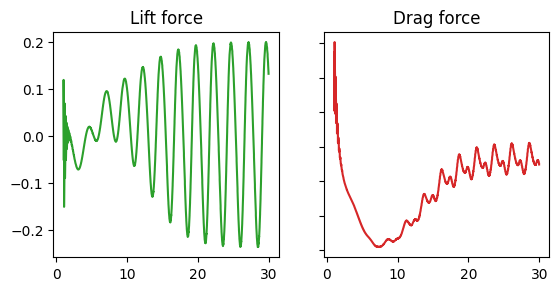

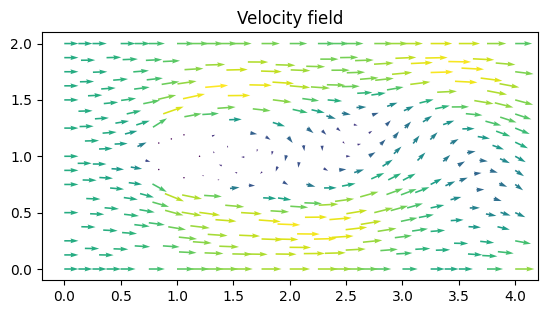

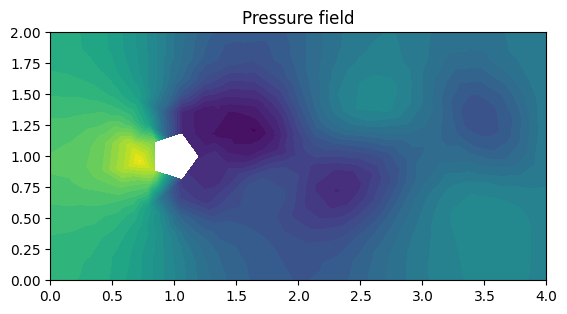

In [9]:
plt.figure()
plot(Mesh16, title="Domain, $Resolution = 16$")
plt.show()

fig, axs = plt.subplots(1,2)
axs[0].plot(Time16,Lift16, 'tab:green')
axs[0].set_title('Lift force')
axs[1].plot(Time16,Drag16, 'tab:red')
axs[1].set_title('Drag force')
for ax in fig.get_axes():
    ax.label_outer()
    ax.set_box_aspect(1)

plt.figure()
plot(Velocity16, title="Velocity field")
plt.show()

plt.figure()
plot(Pressure16, title="Pressure field")
plt.show()

The results obtained for $h=1/32$ are shown below for completeness, although they were presented earlier for the case of $Re=100$ while comparing the various Reynolds numbers.
A Paraview simulation of the flow is also visualized.

In this case, as it was seen, the flow is unsteady beyond doubt and the vortex street has a reasonable value of $St$, sign of the accuracy of the chosen resolution.



In [22]:
Video("velocity_giuseppeanagni_lab2.mp4",embed=True, width=720, height=320)

Output hidden; open in https://colab.research.google.com to view.

In [23]:
Video("pressure_giuseppeanagni_lab2.mp4",embed=True, width=720, height=320)

Output hidden; open in https://colab.research.google.com to view.

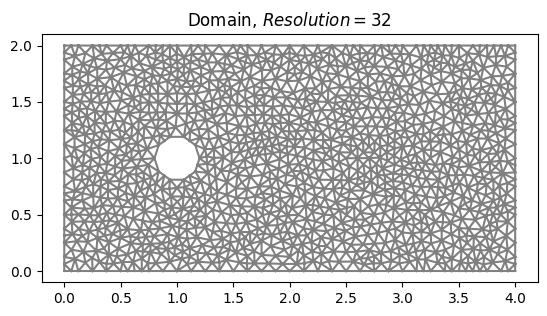

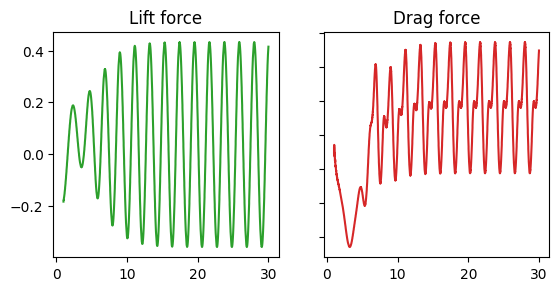

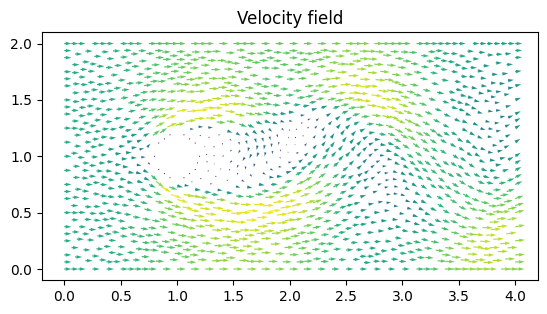

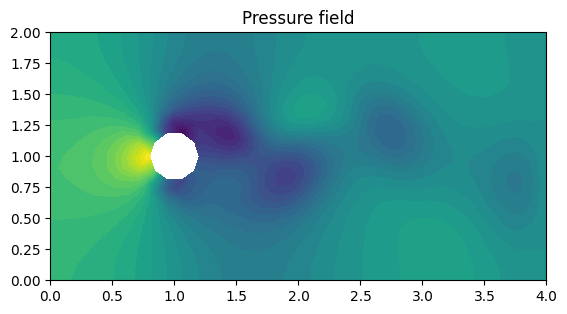

In [11]:
plt.figure()
plot(Mesh, title="Domain, $Resolution = 32$")
plt.show()

fig, axs = plt.subplots(1,2)
axs[0].plot(Time,Lift100, 'tab:green')
axs[0].set_title('Lift force')
axs[1].plot(Time,Drag100, 'tab:red')
axs[1].set_title('Drag force')
for ax in fig.get_axes():
    ax.label_outer()
    ax.set_box_aspect(1)

plt.figure()
plot(Velocity100, title="Velocity field")
plt.show()

plt.figure()
plot(Pressure100, title="Pressure field")
plt.show()

# **Discussion**

A stabilized finite element method was implemented in FEniCS to solve the Navier-Stokes equations in 2D. The method was tested for the model problem of flow past a circular obstacle, and for a high enough Reynolds number and sufficient mesh resolution [a von Karman vortex street developed as expected.](https://en.wikipedia.org/wiki/Kármán_vortex_street)